In [2]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from itertools import combinations
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
import texthero as hero
import regex as re


from torchtext.vocab import FastText
from torchtext.vocab import GloVe

import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext import data
from torchtext import datasets

from collections import Counter
from torchtext.vocab import vocab

import numpy as np
import random
import math

nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download('punkt')
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\K1NG\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\K1NG\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\K1NG\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\K1NG\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Remove those rows where tokens are empty
# Do not remove stop words or lemmatize

,id,comment_text,identity,train_set,label,clean_text,tokens
289,240311,You're an idiot.,0,1,1,idiot,[idiot]
956,241282,NIGGER,1,1,1,nigger,[nigger]
3669,245669,SNITCH,0,1,1,snitch,[snitch]
10992,255750,your an idiot,0,1,1,idiot,[idiot]
13365,258686,cut them.,0,1,1,cut,[cut]
...,...,...,...,...,...,...,...
1896557,7091683,You are the cretin.,0,0,1,cretin,[cretin]
1896762,7091888,Hypocrite!,0,0,1,hypocrite,[hypocrite]
1898580,7093706,Loser.,0,0,1,loser,[loser]
1900680,7095806,Idiot.,0,0,1,idiot,[idiot]


In [3]:
# Check your version
# On Colab, you'll see ('1.10.2+cu102', '0.11.2')
print(torch.__version__, torchtext.__version__)
USE_CUDA = torch.cuda.is_available()
torch.cuda.is_available()

1.10.2+cu113 0.11.2


True

### Loading the data

In [4]:
train = pd.read_csv('./data/jigsaw-unintended-bias-in-toxicity-classification/train.csv')
test = pd.read_csv('./data/jigsaw-unintended-bias-in-toxicity-classification/test_public_expanded.csv')

In [5]:
print(train["target"].isna().value_counts())
train["label"] = train["target"].apply(lambda x: 1 if x>=0.5 else 0)
print(test["toxicity"].isna().value_counts())
test["label"] = test["toxicity"].apply(lambda x: 1 if x>=0.5 else 0)

False    1804874
Name: target, dtype: int64
False    97320
Name: toxicity, dtype: int64


In [6]:
IDENTITY_COLUMNS = ['asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white']

train["identity"] = (train[IDENTITY_COLUMNS].fillna(0).values>=0.5).sum(axis=1).astype(bool).astype(np.int)
test["identity"] = (test[IDENTITY_COLUMNS].fillna(0).values>=0.5).sum(axis=1).astype(bool).astype(np.int)

C:\Users\K1NG\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':
C:\Users\K1NG\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current

In [7]:
train["identity"].value_counts()

0    1634570
1     170304
Name: identity, dtype: int64

In [8]:
train["train_set"] = 1
test["train_set"] = 0

### Now let us select relevant columns of train and test set and merge them together

In [9]:
df1 = train[["id", "comment_text", "identity", "train_set", "label"]]
df2 = test[["id", "comment_text", "identity", "train_set", "label"]]

data = df1.append(df2, ignore_index=True)
data

,id,comment_text,identity,train_set,label
0,59848,"This is so cool. It's like, 'would you want yo...",0,1,0
1,59849,Thank you!! This would make my life a lot less...,0,1,0
2,59852,This is such an urgent design problem; kudos t...,0,1,0
3,59855,Is this something I'll be able to install on m...,0,1,0
4,59856,haha you guys are a bunch of losers.,0,1,1
...,...,...,...,...,...
1902189,7097315,That's the thing...it's called a plan. Get in...,0,0,0
1902190,7097316,"It's not quite the way you describe it, Mike. ...",0,0,0
1902191,7097317,What right have you to criticise? You have no ...,0,0,0
1902192,7097318,My concern is that if China allies with the US...,0,0,0


### Text Preprocessing

#### 1. Creating target variables

<AxesSubplot:title={'center':'Distribution of identities'}>

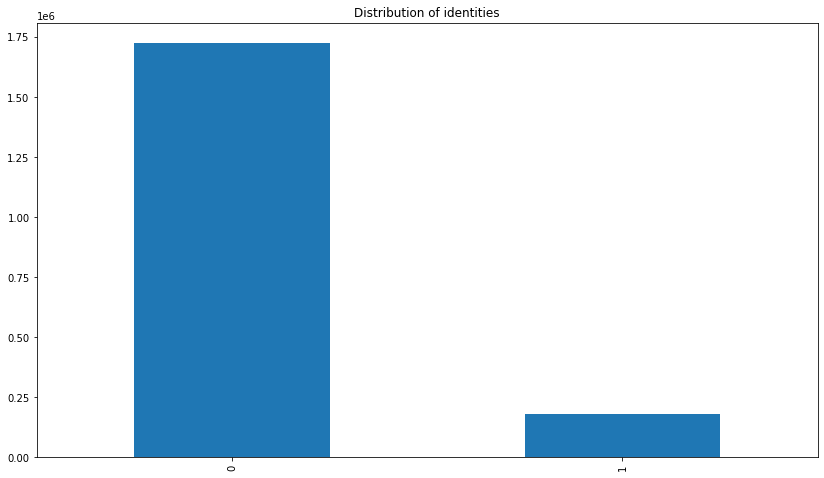

In [9]:
data["identity"].value_counts().plot(kind="bar", figsize=(14,8), title="Distribution of identities")

<AxesSubplot:title={'center':'Distribution of class labels'}>

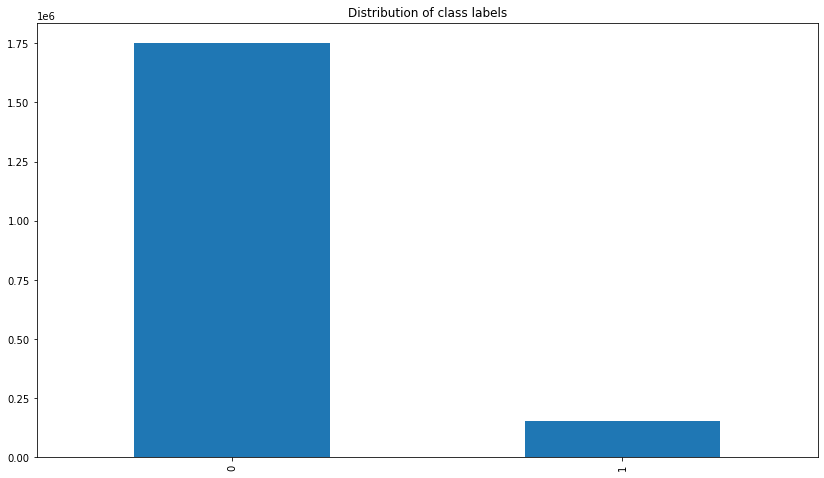

In [10]:
data["label"].value_counts().plot(kind="bar", figsize=(14,8), title="Distribution of class labels")

In [39]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', -1)
# data[["comment_text", "label"]].head(100)
# sh*tty
# ur
# hahahahahahahahhha
# \nsheriff
# whaaaaaatttttt?
# waaaaay
# BwaaaaaaaaaHahahahahaha
# aaaaalmost
# bbbaaaaaa
# Whaaaaaat
# DISCUSSTING

# remove punctuation and replace with an empty single space
# lower level
# downsampling is also important 
# data[data["comment_text"].str.contains("aaaaa") == True][["comment_text", "label"]]

C:\Users\K1NG\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


In [10]:
def preprocess(data):
    '''
    "Try with stop words and without stop words
    Try with and without lemmatization
    '''
    # punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
    # for p in punct:
    #     data["text"] = data.replace(p, ' ')


    # data = data.astype(str).apply(lambda x: clean_special_chars(x, punct))
    # return data
    # data["clean_text"] = data["comment_text"].apply(lambda x: x.replace(r'\n',  ' '))
    data["clean_text"] = data["comment_text"].apply(lambda x: re.sub(r'\n', " ", x))
    data["clean_text"] = data["clean_text"].replace(r'\\n',' ', regex=True)
    data["clean_text"] = data["clean_text"].replace('\n',' ', regex=True)
    # data["clean_text"] = data["comment_text"].apply(lambda x: x.replace('\n',  ' '))

    custom_pipeline = [
        # hero.preprocessing.remove_whitespace,
        # hero.preprocessing.remove_digits,
        hero.preprocessing.remove_punctuation,
        hero.preprocessing.lowercase
        # hero.preprocessing.remove_stopwords
        ]

    data['clean_text'] = hero.clean(data['comment_text'], custom_pipeline)
    # data["clean_text"] = data["clean_text"].apply(lambda x: re.sub(r'[0-9]', "", x))
    # punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
    data["clean_text"] = data["clean_text"].apply(lambda x: re.sub(r"/-'?!.,#$%\'()+-/:;<=>@[\\]^_`{|}~`", "", x))
    data["clean_text"] = data["clean_text"].apply(lambda x: re.sub(r'""“”’', "", x))
    data["clean_text"] = data["clean_text"].apply(lambda x: re.sub(r'∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&', "", x))

    return data

preprocess(data)
data


,id,comment_text,identity,train_set,label,clean_text
0,59848,"This is so cool. It's like, 'would you want yo...",0,1,0,this is so cool it s like would you want yo...
1,59849,Thank you!! This would make my life a lot less...,0,1,0,thank you this would make my life a lot less ...
2,59852,This is such an urgent design problem; kudos t...,0,1,0,this is such an urgent design problem kudos t...
3,59855,Is this something I'll be able to install on m...,0,1,0,is this something i ll be able to install on m...
4,59856,haha you guys are a bunch of losers.,0,1,1,haha you guys are a bunch of losers
...,...,...,...,...,...,...
1902189,7097315,That's the thing...it's called a plan. Get in...,0,0,0,that s the thing it s called a plan get into...
1902190,7097316,"It's not quite the way you describe it, Mike. ...",0,0,0,it s not quite the way you describe it mike ...
1902191,7097317,What right have you to criticise? You have no ...,0,0,0,what right have you to criticise you have no ...
1902192,7097318,My concern is that if China allies with the US...,0,0,0,my concern is that if china allies with the us...


In [41]:
# data.sort_values(by="label", ascending=False)

In [11]:
data["tokens"] = data["clean_text"].apply(lambda x: nltk.tokenize.word_tokenize(x))

In [12]:
def lemmatize_text(text):
    '''
    '''
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in text]

data["tokens"] = data["tokens"].apply(lemmatize_text)
data

,id,comment_text,identity,train_set,label,clean_text,tokens
0,59848,"This is so cool. It's like, 'would you want yo...",0,1,0,this is so cool it s like would you want yo...,"[this, is, so, cool, it, s, like, would, you, ..."
1,59849,Thank you!! This would make my life a lot less...,0,1,0,thank you this would make my life a lot less ...,"[thank, you, this, would, make, my, life, a, l..."
2,59852,This is such an urgent design problem; kudos t...,0,1,0,this is such an urgent design problem kudos t...,"[this, is, such, an, urgent, design, problem, ..."
3,59855,Is this something I'll be able to install on m...,0,1,0,is this something i ll be able to install on m...,"[is, this, something, i, ll, be, able, to, ins..."
4,59856,haha you guys are a bunch of losers.,0,1,1,haha you guys are a bunch of losers,"[haha, you, guy, are, a, bunch, of, loser]"
...,...,...,...,...,...,...,...
1902189,7097315,That's the thing...it's called a plan. Get in...,0,0,0,that s the thing it s called a plan get into...,"[that, s, the, thing, it, s, called, a, plan, ..."
1902190,7097316,"It's not quite the way you describe it, Mike. ...",0,0,0,it s not quite the way you describe it mike ...,"[it, s, not, quite, the, way, you, describe, i..."
1902191,7097317,What right have you to criticise? You have no ...,0,0,0,what right have you to criticise you have no ...,"[what, right, have, you, to, criticise, you, h..."
1902192,7097318,My concern is that if China allies with the US...,0,0,0,my concern is that if china allies with the us...,"[my, concern, is, that, if, china, ally, with,..."


In [14]:


#stopwords = stopwords.words('english')
# stopwords = set(nltk.corpus.stopwords.words('english'))

# Remove single-character tokens (mostly punctuation)
# data["tokens"] = data["tokens"].apply(lambda x: [word for word in x if len(word) > 1])

# # Remove numbers
# #words = [word for word in words if not word.isnumeric()]

# # Remove punctuation
# # words = [word for word in words if word.isalpha()]

# # Lowercase all words (default_stopwords are lowercase too)
# words = [word.lower() for word in words]

# # Remove stopwords
# words = [word for word in words if word not in stopwords]

# fdist = nltk.FreqDist(words)

# print(fdist)

# #fdist.items() - will give all words
# fdist.most_common(500)

In [13]:
# sample weights
# There are four groups
# Identity-Toxic
# Identity-Non toxic
# No identity - Toxic
# No identity - non toxic
# we want equal representation of each of these groups 
# Let us see how many belong to each group 
# Identity and toxic

# identity_toxic = len(data[(data.identity == 1) & (data.label == 1)])
# identity_nontoxic = len(data[(data.identity == 1) & (data.label == 0)])
# nonidentity_toxic = len(data[(data.identity == 0) & (data.label == 1)])
# nonidentity_nontoxic = len(data[(data.identity == 0) & (data.label == 0)])
# print("Identity and toxic=", identity_toxic)
# print("Identity and non-toxic=", identity_nontoxic)
# print("Non-identity and toxic=", nonidentity_toxic)
# print("Non-identity and non-toxic=", nonidentity_nontoxic)

# sample_weight_identity_toxic = len(data)/identity_toxic/4
# sample_weight_identity_nontoxic = len(data)/identity_nontoxic/4
# sample_weight_nonidentity_toxic = len(data)/nonidentity_toxic/4
# sample_weight_nonidentity_nontoxic = len(data)/nonidentity_nontoxic/4

# conditions = [
#     (data.identity == 1) & (data.label == 1),
#     (data.identity == 1) & (data.label == 0),
#     (data.identity == 0) & (data.label == 1),
#     (data.identity == 0) & (data.label == 0)
# ]

# values = [sample_weight_identity_toxic, 
#             sample_weight_identity_nontoxic, 
#             sample_weight_nonidentity_toxic, 
#             sample_weight_nonidentity_nontoxic
#         ]

# data['sample_weight'] = np.select(conditions, values)
# values


#Subgroup: Add all the values of the identities along rows
#Background Positive, Subgroup Negative - Add all values of targets*~identity
# #Background Positive, Subgroup Negative -  Add all values ~targets*identity
data["sample_weight"] = np.ones((len(data),)) + \
    (data["identity"].fillna(0)) + \
        (data['label'] * (~data["identity"].astype(bool)).astype(int)) + \
            ((~data["label"].astype(bool)).astype(int) * data["identity"])

data["sample_weight"]  /= data["sample_weight"] .mean()
data


# # #Overall
# data["sample_weight"] = np.ones((len(data),))

# #Subgroup: Add all the values of the identities along rows
# data["sample_weight"] += (data["identity"].fillna(0))

# #Background Positive, Subgroup Negative - Add all values of targets*~identity
# data["sample_weight"] += data['label'] * (~data["identity"].astype(bool)).astype(int)

# # #Background Positive, Subgroup Negative -  Add all values ~targets*identity
# data["sample_weight"] += (~data["label"].astype(bool)).astype(int) * data["identity"]

# data["sample_weight"]  /= data["sample_weight"] .mean()
# data

,id,comment_text,identity,train_set,label,clean_text,tokens,sample_weight
0,59848,"This is so cool. It's like, 'would you want yo...",0,1,0,this is so cool it s like would you want yo...,"[this, is, so, cool, it, s, like, would, you, ...",0.808275
1,59849,Thank you!! This would make my life a lot less...,0,1,0,thank you this would make my life a lot less ...,"[thank, you, this, would, make, my, life, a, l...",0.808275
2,59852,This is such an urgent design problem; kudos t...,0,1,0,this is such an urgent design problem kudos t...,"[this, is, such, an, urgent, design, problem, ...",0.808275
3,59855,Is this something I'll be able to install on m...,0,1,0,is this something i ll be able to install on m...,"[is, this, something, i, ll, be, able, to, ins...",0.808275
4,59856,haha you guys are a bunch of losers.,0,1,1,haha you guys are a bunch of losers,"[haha, you, guy, are, a, bunch, of, loser]",1.616550
...,...,...,...,...,...,...,...,...
1902189,7097315,That's the thing...it's called a plan. Get in...,0,0,0,that s the thing it s called a plan get into...,"[that, s, the, thing, it, s, called, a, plan, ...",0.808275
1902190,7097316,"It's not quite the way you describe it, Mike. ...",0,0,0,it s not quite the way you describe it mike ...,"[it, s, not, quite, the, way, you, describe, i...",0.808275
1902191,7097317,What right have you to criticise? You have no ...,0,0,0,what right have you to criticise you have no ...,"[what, right, have, you, to, criticise, you, h...",0.808275
1902192,7097318,My concern is that if China allies with the US...,0,0,0,my concern is that if china allies with the us...,"[my, concern, is, that, if, china, ally, with,...",0.808275


In [39]:
train_data[["identity", "label", "sample_weight"]][(train_data.identity==1) & (train_data.label==0)]

,identity,label,sample_weight
11,1,0,2.424826
68,1,0,2.424826
185,1,0,2.424826
191,1,0,2.424826
197,1,0,2.424826
...,...,...,...
1804848,1,0,2.424826
1804850,1,0,2.424826
1804852,1,0,2.424826
1804855,1,0,2.424826


In [16]:
# data["sample_weight"].value_counts()


0.808275    1600589
1.616550     152005
2.424826     149600
Name: sample_weight, dtype: int64

In [637]:
len(data)

1902194

In [636]:
data.shape

(1902194, 8)

In [19]:
len(data)

1902194

In [21]:
train_data = data[data.train_set==1]
test_data = data[data.train_set==0]

# train_data.to_csv("train_set.csv")
# test_data.to_csv("test_set.csv")

In [22]:
train_data.tokens.isna().value_counts()

False    1804874
Name: tokens, dtype: int64

In [46]:
data.groupby(["label"]).count()

,id,comment_text,identity,train_set,clean_text,tokens,sample_weight
label,,,,,,,
0,1750189,1750189,1750189,1750189,1750189,1750189,1750189
1,152005,152005,152005,152005,152005,152005,152005


In [31]:
train_data[train_data["tokens"].apply(lambda x: len(x)==1)]

,id,comment_text,identity,train_set,label,clean_text,tokens,sample_weight
7,59863,FFFFUUUUUUUUUUUUUUU,0,1,0,ffffuuuuuuuuuuuuuuu,[ffffuuuuuuuuuuuuuuu],0.808275
35,239616,Awesome!,0,1,0,awesome,[awesome],0.808275
294,240316,Perhaps!,0,1,0,perhaps,[perhaps],0.808275
375,240431,log,0,1,0,log,[log],0.808275
413,240481,101th!,0,1,0,101th,[101th],0.808275
...,...,...,...,...,...,...,...,...
1804385,6333176,Nonsense,0,1,0,nonsense,[nonsense],0.808275
1804413,6333213,prolly!,0,1,0,prolly,[prolly],0.808275
1804606,6333483,How?,0,1,0,how,[how],0.808275
1804654,6333556,Exactly.,0,1,0,exactly,[exactly],0.808275


### Removing rows from train set that have zero tokens

In [23]:
train_data = train_data[train_data["tokens"].apply(lambda x: len(x)!=0)]
train_data

,id,comment_text,identity,train_set,label,clean_text,tokens,sample_weight
0,59848,"This is so cool. It's like, 'would you want yo...",0,1,0,this is so cool it s like would you want yo...,"[this, is, so, cool, it, s, like, would, you, ...",0.808275
1,59849,Thank you!! This would make my life a lot less...,0,1,0,thank you this would make my life a lot less ...,"[thank, you, this, would, make, my, life, a, l...",0.808275
2,59852,This is such an urgent design problem; kudos t...,0,1,0,this is such an urgent design problem kudos t...,"[this, is, such, an, urgent, design, problem, ...",0.808275
3,59855,Is this something I'll be able to install on m...,0,1,0,is this something i ll be able to install on m...,"[is, this, something, i, ll, be, able, to, ins...",0.808275
4,59856,haha you guys are a bunch of losers.,0,1,1,haha you guys are a bunch of losers,"[haha, you, guy, are, a, bunch, of, loser]",1.616550
...,...,...,...,...,...,...,...,...
1804869,6333967,"Maybe the tax on ""things"" would be collected w...",0,1,0,maybe the tax on things would be collected w...,"[maybe, the, tax, on, thing, would, be, collec...",0.808275
1804870,6333969,What do you call people who STILL think the di...,0,1,0,what do you call people who still think the di...,"[what, do, you, call, people, who, still, thin...",0.808275
1804871,6333982,"thank you ,,,right or wrong,,, i am following ...",0,1,0,thank you right or wrong i am following your...,"[thank, you, right, or, wrong, i, am, followin...",0.808275
1804872,6334009,Anyone who is quoted as having the following e...,0,1,1,anyone who is quoted as having the following e...,"[anyone, who, is, quoted, a, having, the, foll...",1.616550


,id,comment_text,identity,train_set,label,clean_text,tokens,sample_weight
4,59856,haha you guys are a bunch of losers.,0,1,1,haha you guys are a bunch of losers,"[haha, you, guy, are, a, bunch, of, loser]",1.61655
5,59859,ur a sh*tty comment.,0,1,1,ur a sh tty comment,"[ur, a, sh, tty, comment]",1.61655
13,239583,It's ridiculous that these guys are being call...,0,1,1,it s ridiculous that these guys are being call...,"[it, s, ridiculous, that, these, guy, are, bei...",1.61655
14,239584,This story gets more ridiculous by the hour! A...,0,1,1,this story gets more ridiculous by the hour a...,"[this, story, get, more, ridiculous, by, the, ...",1.61655
19,239592,"Angry trolls, misogynists and Racists"", oh my....",0,1,1,angry trolls misogynists and racists oh my ...,"[angry, troll, misogynist, and, racist, oh, my...",1.61655
...,...,...,...,...,...,...,...,...
1804825,6333841,Who is the jerk in the last row between the C ...,0,1,1,who is the jerk in the last row between the c ...,"[who, is, the, jerk, in, the, last, row, betwe...",1.61655
1804838,6333871,Nobody really cares that she supports the scie...,0,1,1,nobody really cares that she supports the scie...,"[nobody, really, care, that, she, support, the...",1.61655
1804856,6333923,Believing in God or not believing in God are p...,1,1,1,believing in god or not believing in god are p...,"[believing, in, god, or, not, believing, in, g...",1.61655
1804857,6333927,"I take your point, but I think you're shooting...",0,1,1,i take your point but i think you re shooting...,"[i, take, your, point, but, i, think, you, re,...",1.61655


In [24]:
# No Identity and toxix: 116371
# No Identity and non-toxic: 1517979
# identity and toxic: 27963 
# identity and non-toxic: 142341 
# total train data size: 1804654 
# total non toxic comments: 1660320
# total toxic comments: 144334

# # Let us under-sample the first three groups
# train_data1 = train_data[(train_data.identity==0) & (train_data.label==1)].sample(frac=0.30, random_state=0)
# train_data2 = train_data[(train_data.identity==0) & (train_data.label==0)].sample(frac=0.02, random_state=0)
# train_data3 = train_data[(train_data.identity==1) & (train_data.label==1)]
# train_data4 = train_data[(train_data.identity==1) & (train_data.label==0)]

# Let us undersample the non-toxic group
train_data1 = train_data[train_data.label==0].sample(frac=0.087, random_state=0)
train_data2 = train_data[train_data.label==1]

train_data = train_data1.append(train_data2)
train_data.groupby(["label"]).count()


,id,comment_text,identity,train_set,clean_text,tokens,sample_weight
label,,,,,,,
0,144448,144448,144448,144448,144448,144448,144448
1,144334,144334,144334,144334,144334,144334,144334


In [61]:
train_data

,id,comment_text,identity,train_set,label,clean_text,tokens,sample_weight
1061654,5414429,Stupid Politics is stupid no matter what side ...,0,1,1,stupid politics is stupid no matter what side ...,"[stupid, politics, is, stupid, no, matter, wha...",1.616550
134930,406832,Outsourcing to the L48 is where the major gang...,0,1,1,outsourcing to the l48 is where the major gang...,"[outsourcing, to, the, l48, is, where, the, ma...",1.616550
949651,5280417,"What's that old saying..."" Be careful what wis...",0,1,1,what s that old saying be careful what wish f...,"[what, s, that, old, saying, be, careful, what...",1.616550
626163,1008214,You don't have to be smart to be dangerous. Mo...,0,1,1,you don t have to be smart to be dangerous mo...,"[you, don, t, have, to, be, smart, to, be, dan...",1.616550
1267603,5664056,Trump as President.....it is to laugh. The w...,0,1,1,trump as president it is to laugh the whole...,"[trump, a, president, it, is, to, laugh, the, ...",1.616550
...,...,...,...,...,...,...,...,...
1804848,6333897,Women's rights? Last I checked women were jus...,1,1,0,women s rights last i checked women were jus...,"[woman, s, right, last, i, checked, woman, wer...",2.424826
1804850,6333907,"Every time there are testimonies, like this, I...",1,1,0,every time there are testimonies like this i...,"[every, time, there, are, testimony, like, thi...",2.424826
1804852,6333915,Xi and his comrades must be smirking over Trum...,1,1,0,xi and his comrades must be smirking over trum...,"[xi, and, his, comrade, must, be, smirking, ov...",2.424826
1804855,6333920,It is of course normal and natural for Eugene ...,1,1,0,it is of course normal and natural for eugene ...,"[it, is, of, course, normal, and, natural, for...",2.424826


,id,comment_text,identity,train_set,label,clean_text,tokens,sample_weight
1061654,5414429,Stupid Politics is stupid no matter what side ...,0,1,1,stupid politics is stupid no matter what side ...,"[stupid, politics, is, stupid, no, matter, wha...",1.616550
134930,406832,Outsourcing to the L48 is where the major gang...,0,1,1,outsourcing to the l48 is where the major gang...,"[outsourcing, to, the, l48, is, where, the, ma...",1.616550
949651,5280417,"What's that old saying..."" Be careful what wis...",0,1,1,what s that old saying be careful what wish f...,"[what, s, that, old, saying, be, careful, what...",1.616550
626163,1008214,You don't have to be smart to be dangerous. Mo...,0,1,1,you don t have to be smart to be dangerous mo...,"[you, don, t, have, to, be, smart, to, be, dan...",1.616550
1267603,5664056,Trump as President.....it is to laugh. The w...,0,1,1,trump as president it is to laugh the whole...,"[trump, a, president, it, is, to, laugh, the, ...",1.616550
...,...,...,...,...,...,...,...,...
1804848,6333897,Women's rights? Last I checked women were jus...,1,1,0,women s rights last i checked women were jus...,"[woman, s, right, last, i, checked, woman, wer...",2.424826
1804850,6333907,"Every time there are testimonies, like this, I...",1,1,0,every time there are testimonies like this i...,"[every, time, there, are, testimony, like, thi...",2.424826
1804852,6333915,Xi and his comrades must be smirking over Trum...,1,1,0,xi and his comrades must be smirking over trum...,"[xi, and, his, comrade, must, be, smirking, ov...",2.424826
1804855,6333920,It is of course normal and natural for Eugene ...,1,1,0,it is of course normal and natural for eugene ...,"[it, is, of, course, normal, and, natural, for...",2.424826


### Distribution of class after under-sampling

In [77]:
train_data.groupby(["label"]).count()

,id,comment_text,identity,train_set,clean_text,tokens,sample_weight
label,,,,,,,
0,138161,138161,138161,138161,138161,138161,138161
1,50302,50302,50302,50302,50302,50302,50302


In [63]:
# import random

# undersample = random.sample(, random_state=0)

# train_data = undersample.fit(train_data)


From henceforth, I have forked "final_project_sa.ipynb" to run the Deep Neural Network models

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext

from collections import Counter
from torchtext.vocab import vocab

import numpy as np
import random

In [26]:
# Check the library versions
torch.__version__, torchtext.__version__

('1.10.2+cu113', '0.11.2')

In [27]:
import torchtext
from torchtext.vocab import Vectors
import torch
import numpy as np
import random

USE_CUDA = torch.cuda.is_available()

if USE_CUDA:
    DEVICE = torch.device('cuda')
    print("Using cuda.")
else:
    DEVICE = torch.device('cpu')
    print("Using cpu.")

random.seed(30255)
np.random.seed(30255)
torch.manual_seed(30255)
if USE_CUDA:
    torch.cuda.manual_seed(30255)

# # Change the following to false when training on
# # the full set
# DEVELOPING = True    
# # DEVELOPING = False

# if DEVELOPING:
#     print('Small development version')
#     BATCH_SIZE = 4
#     EMBEDDING_SIZE = 20
#     MAX_VOCAB_SIZE = 5000
#     TRAIN_DATA_SET = "train_set.csv"
#     TEST_DATA_SET = "test_set.csv"
#     BPTT_LENGTH = 8
# else:
#     print('Full version')
#     BATCH_SIZE = 32
#     EMBEDDING_SIZE = 650
#     MAX_VOCAB_SIZE = 50000
#     TRAIN_DATA_SET = "train_set.csv"
#     TEST_DATA_SET = "test_set.csv"
#     BPTT_LENGTH = 32


Using cuda.


In [28]:
torch.cuda.is_available()

True

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [30]:
GLOVE = GloVe(name='6B', dim=100)
FASTTEXT = FastText('simple')

In [31]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=25)


In [32]:
train = list(train_data[["tokens", "label", "sample_weight"]].to_records(index=False))
val = list(val_data[["tokens", "label", "sample_weight"]].to_records(index=False))
test = list(test_data[["tokens", "label", "sample_weight"]].to_records(index=False))
# train_target = train_data["label"]
# val_target = val_data["label"]
# test_target = test_data["label"]

### Creating Vocab (Word-to-Index)

In [84]:
# TEXT = torchtext.legacy.data.Field(lower=True)

In [186]:
# train

In [33]:
from torchtext.vocab import Vocab

counter_words = Counter()
for tokens, _, _ in train:
    counter_words.update(tokens)



In [34]:
len(counter_words)

100261

In [35]:
# from torchtext.vocab import vocab

# vocab_words = vocab(counter_words)
# vocab_words.set_default_index(0)

# vocab_words = torchtext.vocab.build_vocab_from_iterator(counter_words, specials=["<unk>", "<pad>"], special_first=True)

from torchtext.legacy.vocab import Vocab as retired_vocab

vocab_words = retired_vocab(counter_words, specials=["<pad>", "<unk>"], specials_first=True)

print("Number of unique words:", len(vocab_words))

Number of unique words: 100263


In [247]:
# vocab_words.itos

### Creating the collate function that converts the batch data to tensors

In [270]:
# from torch.utils.data import DataLoader
# from torch.nn.utils.rnn import pad_sequence

# def collate_fn(batch):
    
#     ## WRITE YOUR CODE BELOW
#     word_idxs = []
#     labels = []
#     for tokens, label in batch:
#         word_idxs.append(vocab_words.lookup_indices(tokens))
#         labels.append(label)
#     word_idxs = torch.tensor(word_idxs, dtype=torch.int32)
#     word_idxs = word_idxs.T

#     # word_idxs = pad_sequence([tokens for tokens, _ in batch], batch_first=False)
#     labels = torch.tensor(labels, dtype=torch.int32)    
    
#     return word_idxs.to(device), labels.to(device)

In [36]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pack_sequence, pad_sequence

def collate_fn(batch):
    
    ## WRITE YOUR CODE BELOW
    word_idxs = []
    labels = []
    sample_weights=[]
    for tokens, label, sample_weight in batch:
        # print("Tokens=", tokens)
        # print("Labels=", label)
        token_tensor = torch.tensor(vocab_words.lookup_indices(tokens), dtype=torch.int32)
        word_idxs.append(token_tensor)
        # print("List of text_tensors=", word_idxs)
        labels.append(label)
        sample_weights.append(sample_weight)
    # seq_lengths = torch.LongTensor([v for v in map(len, word_idxs)])
    # max_len = max([len(v) for v in word_idxs])

    #packing sequence
    word_idxs = pad_sequence(word_idxs, batch_first=True)
    # print("padded text_tensors=", word_idxs)
    # word_idxs = torch.tensor(word_idxs, dtype=torch.int32)
    word_idxs = word_idxs.T
    # print("transposed text_tensors=", word_idxs)
    # word_idxs = pad_sequence([tokens for tokens, _ in batch], batch_first=False)
    labels = torch.tensor(labels, dtype=torch.int32) 
    labels = labels.type(torch.LongTensor)
    sample_weights = torch.tensor(labels, dtype=torch.float32) 
    # print("Label tensors")
    
    return word_idxs.to(device), labels.to(device), sample_weights.to(device)

In [286]:
# from torch.nn.utils.rnn import pad_sequence

# b = torch.tensor([1,2,3])
# a = torch.tensor([4,5])
# c = torch.tensor([6])
# pad_sequence([a,b,c], batch_first=True).T

tensor([[4, 1, 6],
        [5, 2, 0],
        [0, 3, 0]])

### Creating the DataLoaders

In [37]:
BATCH_SIZE = 64 # batch size for training

train_dataloader = DataLoader(train, batch_size=BATCH_SIZE,
                              shuffle=True, 
                              collate_fn=collate_fn)
valid_dataloader = DataLoader(val, batch_size=BATCH_SIZE,
                              shuffle=False, 
                              collate_fn=collate_fn)
test_dataloader = DataLoader(test, batch_size=BATCH_SIZE,
                             shuffle=False, 
                             collate_fn=collate_fn)

In [375]:
# train_dataloader = DataLoader(a, batch_size=BATCH_SIZE,
#                               shuffle=True, 
#                               collate_fn=collate_fn)

In [266]:
# max_length = 0
# length_list = []
# for sequence, label in train:
#     current_length = len(sequence)
#     length_list.append(current_length)
#     if current_length > max_length:
#         max_length = current_length

# max_length

304

In [269]:
# len(train_dataloader)

36098

In [192]:
# 1155119/32

36097.46875

### Creating Embeddings

In [38]:
from torchtext import vocab

fasttext = vocab.FastText('simple')
fasttext_vectors = fasttext.get_vecs_by_tokens(vocab_words.itos)

In [39]:
fasttext_vectors.size()

torch.Size([100263, 300])

### Writing the class for the LSTM Model

In [40]:
import torch
import torch.nn as nn
# from torch.autograd import Variable


class RNNLM(nn.Module):
    """ Container module with an linear encoder/embedding, an RNN module, and a linear decoder.
    """
    def __init__(self, rnn_type, vocab_size, embedding_dim, hidden_dim, num_layers, output_dim, 
                 dropout=0.5, use_fasttext=False, freeze_fasttext=False, bidirectional=False):
        ''' Initialize model parameters corresponding to ---
            - embedding layer
            - recurrent neural network layer---one of LSTM, GRU, or RNN---with 
              optionally more than one layer
            - linear layer to map from hidden vector to the vocabulary
            - optionally, dropout layers.  Dropout layers can be placed after 
              the embedding layer or/and after the RNN layer. Dropout within
              an RNN is only applied when there are two or more num_layers.
            - optionally, initialize the model parameters.
            
            The arguments are:
            
            rnn_type: One of 'LSTM', 'GRU', 'RNN_TANH', 'RNN_RELU'
            vocab_size: size of vocabulary
            embedding_dim: size of an embedding vector
            hidden_dim: size of hidden/state vector in RNN
            num_layers: number of layers in RNN
            dropout: dropout probability.
            
        '''
        super(RNNLM, self).__init__()
        
        if use_fasttext:
          self.embedding = nn.Embedding.from_pretrained(fasttext_vectors, freeze=freeze_fasttext)
        else:
          self.embedding = nn.Embedding(vocab_size, embedding_dim)
        if rnn_type == "LSTM":
          self.rnn = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=num_layers, dropout=dropout, bidirectional=bidirectional)
        self.dropout = nn.Dropout(0.5)
        self.linear = nn.Linear(hidden_dim, output_dim)
        self.hidden_size = hidden_dim
        self.num_layers = num_layers
        self.D = 1
        if bidirectional:
          self.D = 2
        

    def forward(self, input, hidden0=None):
        ''' 
        Run forward propagation for a given minibatch of inputs using
        hidden0 as the initial hidden state.

        In LSTMs hidden0 = (h_0, c_0). 

        The output of the RNN includes the hidden vector hiddenn = (h_n, c_n).
        Return this as well so that it can be used to initialize the next
        batch.
        
        Unlike previous homework sets do not apply softmax or logsoftmax here, since we'll use
        the more efficient CrossEntropyLoss.  See 
        https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html.
        '''
        batch_size = input.size(-1)
        if not hidden0:
          h_n = torch.zeros(self.D * self.num_layers, batch_size, self.hidden_size).cuda()
          c_n = torch.zeros(self.D * self.num_layers, batch_size, self.hidden_size).cuda()
        else:
          h_n, c_n = hidden0
        
        embeds = self.embedding(input).cuda()
        x, (h_n, c_n) = self.rnn(embeds, (h_n, c_n))
        x = self.dropout(x)
        y = self.linear(x[-1])

        return y
        
 

In [66]:
a = torch.zeros(2,3,4)
a.shape

torch.Size([2, 3, 4])

In [67]:
a[-1].shape

torch.Size([3, 4])

In [73]:
a[-1] = torch.tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])

In [75]:
a

tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]]])

In [439]:
# evaluate(model, data)

Prediction format =  tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Actual format =  tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Prediction format =  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Actual format =  tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')


0.206921019337394

In [574]:


b =  torch.tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])
c =  torch.tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

int((b==c).sum())
len(b)


32

In [41]:
import warnings
warnings.simplefilter("ignore", UserWarning)

### Evaluate on the Validator Dataset

In [42]:
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score

def evaluate(model, data):
    '''
    Evaluate the model on the given data.
    '''
    # print("Entered evaluation")
    model.eval()
    it = iter(data)
    total_pred = 0. # Number of target words seen
    total_correct_pred = 0. # Loss over all target words
    true_positives = 0
    predicted_positives = 0
    actual_positives = 0
    with torch.no_grad():
        # No gradients need to be maintained during evaluation
        # There are no hidden tensors for the first batch, and so will default to zeros.
        # hidden = None 
        for i, batch in enumerate(it):
            ''' Do the following:
                - Extract the text and target from the batch, and if using CUDA (essentially, using GPUs), place 
                  the tensors on cuda, using a commands such as "text = text.cuda()".  More details are at
                  https://pytorch.org/docs/stable/notes/cuda.html.
                - Pass the hidden state vector from output of previous batch as the initial hidden vector for
                  the current batch. 
                - Call forward propagation to get output and final hidden state vector.
                - Compute the cross entropy loss
                - The loss_fn computes the average loss per target word in the batch.  Count the number of target
                  words in the batch (it is usually the same, except for the last batch), and use it to track the 
                  total count (of target words) and total loss see so far over all batches.
            '''
            # print("Entered batch")
            # print(batch[0].shape)
            text, target, sample_weight = batch
            if USE_CUDA:
                text, target, sample_weight = text.cuda(), target.cuda(), sample_weight.cuda()
            # hidden = None
            # print("Evaluate=", text.shape, target.shape)
            output = model(text)
            loss = loss_fn(output.view(-1, output.size(-1)), target.view(-1))
            # loss = (loss*sample_weight).mean()
            # print("Shape of the output=", output.shape)
            pred = F.softmax(output.view(-1, output.size(-1)), dim=1)
            pred = pred.argmax(dim=1)
            # print("Predicted output= ", pred)
            # print("Output format = ", output.view(-1, output.size(-1)))
            # print("Prediction format = ", pred)
            # print("Actual output = ", target.view(-1))

            # calculate accuracy      
            total_pred += len(pred)
            total_correct_pred += int((pred==target.view(-1)).sum())

            # calculate precision
            true_positives += precision_score(target.view(-1).cpu(), pred.cpu()) * (torch.count_nonzero(pred))
            predicted_positives += ((torch.count_nonzero(pred)))
            # precision = true_positives/predicted_positives

            # calculate recall
            # true_positives += (recall_score(target.view(-1).cpu(), pred.cpu()) * (torch.count_nonzero(target.view(-1))))
            actual_positives += ((torch.count_nonzero(target.view(-1))))
            # recall = true_positives/actual_positives
                
    accuracy = (total_correct_pred / total_pred)
    precision = (true_positives/predicted_positives)
    recall = (true_positives/actual_positives)
    f1score = (2*precision*recall)/(precision+recall)
    print("Accuracy=", accuracy)
    print("Precision=", precision)
    print("Recall=", recall)
    print("F1-Score=", f1score)

    # model.train()
    return accuracy, precision, recall, f1score


In [620]:
pre = torch.tensor([1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')

act = torch.tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

true_positives = (recall_score(act.cpu(), pre.cpu()) * (torch.count_nonzero(act)))
actual_positives = (torch.count_nonzero(act))
(true_positives/actual_positives)

tensor(0.8333, device='cuda:0')

In [622]:
val_loss, precision, recall = evaluate(model, valid_dataloader)

Accuracy= 0.8761354664450447
Precision= tensor(0.3830, device='cuda:0')
Recall= tensor(0.8910, device='cuda:0')


In [601]:
a =  torch.tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]).cuda()
b =  torch.tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]).cuda()

precision_score(b.cpu(), a.cpu()) * (torch.count_nonzero(a))
# torch.count_nonzero(a) + torch.count_nonzero(b)

tensor(6., device='cuda:0')

In [477]:
# from sklearn.utils import class_weight

# y = list(train_data[["label"]].to_records(index=False))
# class_weights=class_weight.compute_class_weight('balanced',np.unique(y),y)
# print(class_weights)

### Creating class weights

In [85]:
from sklearn.utils import class_weight

# class_weights 
y = train_data["label"].tolist()
class_weights=class_weight.compute_class_weight('balanced',np.unique(y),y)
class_weights = torch.tensor(class_weights, dtype=torch.float32)
# print(class_weights[0])
# print(class_weights[1])
class_weights
# class_weights=class_weight.compute_class_weight('balanced',np.unique(y),y)
# array([0.54342593, 6.25692904])



tensor([0.6820, 1.8733])

In [567]:
class_weights

tensor([0.5434, 6.2569])

In [497]:
# c = Counter(y)

In [501]:
# c

Counter({0: 1328515, 1: 115384})

In [510]:
# 1443899/1328515/2

0.543425930456186

In [90]:
188463/64

2944.734375

In [509]:
# print(class_weights[0])
# print(class_weights[1])

0.543425930456186
6.256929036954864


### Train the Model: LSTM with randomly initialized embeddings

In [91]:
from sklearn.utils import class_weight

GRAD_CLIP = 1.
NUM_EPOCHS = 10
VOCAB_SIZE = len(vocab_words)
EMBEDDING_SIZE = 300
OUTPUT_DIM = 2

# def repackage_hidden(h):
#     """Wraps hidden states in new Tensors, to detach them from their history."""
#     if h is None:
#         return None
#     elif isinstance(h, torch.Tensor):
#         return h.detach()
#     else:
#         return tuple(repackage_hidden(v) for v in h)

model = RNNLM("LSTM", VOCAB_SIZE, EMBEDDING_SIZE, EMBEDDING_SIZE, 2, OUTPUT_DIM, dropout=0.5)
if USE_CUDA:
    model = model.cuda()

# Using weighted loss given the class is imbalanced and also loss should be the size of the batch
# loss_fn = nn.CrossEntropyLoss(weight=class_weights.cuda(), reduction='none') ## Used instead of NLLLoss.
loss_fn = nn.CrossEntropyLoss(weight=class_weights.cuda())
# loss_fn = nn.CrossEntropyLoss(reduction='none')
# loss_fn = F.binary_cross_entropy_with_logits()



learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
val_losses = []
best_f1score = 0
precision_list = []
recall_list = []
f1score_list = []
least_loss = math.inf
best_model = None

for epoch in range(NUM_EPOCHS):
    # print("Epoch 1")
    model.train()
    it = iter(train_dataloader)
    # print("Length of the total batches=", it)
    log_interval_1 = 100
    log_interval_2 = 100
    # There are no hidden tensors for the first batch, and so will default to zeros.
    # hidden = None
    for i, batch in enumerate(it):
      # print("Length of the batch=", batch[0].shape)
      text, target, sample_weight = batch
      if USE_CUDA:
        text, target, sample_weight = text.cuda(), target.cuda(), sample_weight.cuda()
        # print("Target:", target)
      # hidden = None
      # hidden = repackage_hidden(hidden)
      # print(text)
      model.zero_grad()

      # forward pass
      output = model(text)
      # pred = torch.argmax(F.softmax(output, dim=1), dim=1)
      # print("Output: ", output.shape, output)
      # print("Prediction: ", pred.shape, pred)
      # print("Shape=", output.shape)
      # print(output.size(-1))
      # print(output.view(-1, output.size(-1)).shape)
      # print(target.view(-1).shape)
      loss = loss_fn(output.view(-1, output.size(-1)), target.view(-1))
      # loss = F.binary_cross_entropy_with_logits(pred, target.view(-1), weight=sample_weight, pos_weight=class_weight)
      # loss = loss * sample_weight
      # loss = loss.mean()

      #back propagation
      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(), max_norm=GRAD_CLIP, norm_type=2)
      optimizer.step()

      if i % log_interval_1 == 0 and i > 0:
        print(f'At iteration {i} the loss is {loss:.3f}.')

      if i % log_interval_2 == 0 and i > 0:
        val_loss, precision, recall, f1score = evaluate(model, valid_dataloader)
        val_losses.append(val_loss)
        precision_list.append(precision)
        recall_list.append(recall)
        f1score_list.append(f1score)
        if f1score > best_f1score:
          best_f1score = f1score
          best_model = type(model)("LSTM", VOCAB_SIZE, EMBEDDING_SIZE, EMBEDDING_SIZE, 2, OUTPUT_DIM, dropout=0.5) # get a new instance
          best_model.load_state_dict(model.state_dict()) # copy weights and biases  
        model.train()   
        
        ''' Do the following:
            - Extract the text and target from the batch, and if using CUDA (essentially, using GPUs), place 
              the tensors on cuda, using a commands such as "text = text.cuda()".  More details are at
              https://pytorch.org/docs/stable/tensors.html#torch.Tensor.cuda
            - Pass the hidden state vector from output of previous batch as the initial hidden vector for
              the current batch. But detach each tensor in the hidden state vector using tensor.detach() or
              the provided repackage_hidden(). See
              https://pytorch.org/docs/master/generated/torch.Tensor.detach_.html#torch-tensor-detach
            - Zero out the model gradients to reset backpropagation for current batch
            - Call forward propagation to get output and final hidden state vector.
            - Compute the cross entropy loss
            - Run back propagation to set the gradients for each model parameter.
            - Clip the gradients that may have exploded. See Sec 5.2.4 in the Goldberg textbook, and
              https://pytorch.org/docs/master/generated/torch.nn.utils.clip_grad_norm_.html#torch-nn-utils-clip-grad-norm
            - Run a step of gradient descent. 
            - Print the batch loss after every few iterations. (Say every 100 when developing, every 1000 otherwise.)
            - Evaluate your model on the validation set after every, say, 10000 iterations and save it to val_losses. If
              your model has the lowest validation loss so far, copy it to best_model. For that it is recommended that
              copy the state_dict rather than use deepcopy, since the latter doesn't work on Colab.  See discussion at 
              https://discuss.pytorch.org/t/deep-copying-pytorch-modules/13514. This is Early Stopping and is described
              in Sec 2.3.1 of Lecture notes by Cho: 
              https://github.com/nyu-dl/NLP_DL_Lecture_Note/blob/master/lecture_note.pdf
        '''
    
        
        

At iteration 100 the loss is 0.705.
Accuracy= 0.732978181509466
Precision= tensor(0.2000, device='cuda:0')
Recall= tensor(0.0002, device='cuda:0')
F1-Score= tensor(0.0005, device='cuda:0')
At iteration 200 the loss is 0.690.
Accuracy= 0.3116775617624586
Precision= tensor(0.2747, device='cuda:0')
Recall= tensor(0.9633, device='cuda:0')
F1-Score= tensor(0.4275, device='cuda:0')
At iteration 300 the loss is 0.685.
Accuracy= 0.3933907802020545
Precision= tensor(0.2926, device='cuda:0')
Recall= tensor(0.8979, device='cuda:0')
F1-Score= tensor(0.4413, device='cuda:0')
At iteration 400 the loss is 0.687.
Accuracy= 0.5536972578317344
Precision= tensor(0.3330, device='cuda:0')
Recall= tensor(0.6705, device='cuda:0')
F1-Score= tensor(0.4450, device='cuda:0')
At iteration 500 the loss is 0.665.
Accuracy= 0.6443670939808133
Precision= tensor(0.3656, device='cuda:0')
Recall= tensor(0.4528, device='cuda:0')
F1-Score= tensor(0.4046, device='cuda:0')
At iteration 600 the loss is 0.693.
Accuracy= 0.529

In [92]:
torch.save(best_model.state_dict(), "best-model-parameters-lstm-class-weights-without-embed-f1score_keepstop_undersampling1pt")
accuracy, precision, recall, f1score = evaluate(best_model.cuda(), test_dataloader)

Accuracy= 0.8648581997533908
Precision= tensor(0.3522, device='cuda:0')
Recall= tensor(0.8513, device='cuda:0')
F1-Score= tensor(0.4982, device='cuda:0')


In [93]:
accuracy, precision, recall, f1score = evaluate(model.cuda(), test_dataloader)

Accuracy= 0.8447184545828196
Precision= tensor(0.3087, device='cuda:0')
Recall= tensor(0.7824, device='cuda:0')
F1-Score= tensor(0.4427, device='cuda:0')


In [100]:
# for i, score in enumerate(f1score_list):
    # print(i, score)

In [98]:
torch.argmax(torch.tensor(f1score_list))

tensor(58)

In [43]:
from sklearn.utils import class_weight

GRAD_CLIP = 1.
NUM_EPOCHS = 3
VOCAB_SIZE = len(vocab_words)
EMBEDDING_SIZE = 300
OUTPUT_DIM = 2

# def repackage_hidden(h):
#     """Wraps hidden states in new Tensors, to detach them from their history."""
#     if h is None:
#         return None
#     elif isinstance(h, torch.Tensor):
#         return h.detach()
#     else:
#         return tuple(repackage_hidden(v) for v in h)

model = RNNLM("LSTM", VOCAB_SIZE, EMBEDDING_SIZE, EMBEDDING_SIZE, 2, OUTPUT_DIM, dropout=0.5)
if USE_CUDA:
    model = model.cuda()

# Using weighted loss given the class is imbalanced and also loss should be the size of the batch
# loss_fn = nn.CrossEntropyLoss(weight=class_weights.cuda(), reduction='none') ## Used instead of NLLLoss.
loss_fn = nn.CrossEntropyLoss()
# loss_fn = nn.CrossEntropyLoss(reduction='none')
# loss_fn = F.binary_cross_entropy_with_logits()



learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
val_losses = []
best_f1score = 0
train_total_correct_pred = 0
val_precision_list = []
val_recall_list = []
val_f1score_list = []
val_accuracy_list = []
train_precision_list = []
train_recall_list = []
train_f1score_list = []
train_accuracy_list = []
train_total_pred = 0
train_true_positives = 0
train_predicted_positives = 0
least_loss = math.inf
train_actual_positives = 0
best_model = None

for epoch in range(NUM_EPOCHS):
    print("******************")
    model.train()
    it = iter(train_dataloader)
    # print("Length of the total batches=", it)
    log_interval_1 = 100
    log_interval_2 = 100
    # There are no hidden tensors for the first batch, and so will default to zeros.
    # hidden = None
    for i, batch in enumerate(it):
      # print("Length of the batch=", batch[0].shape)
      text, target, sample_weight = batch
      if USE_CUDA:
        text, target, sample_weight = text.cuda(), target.cuda(), sample_weight.cuda()
        # print("Target:", target)
      # hidden = None
      # hidden = repackage_hidden(hidden)
      # print(text)
      model.zero_grad()

      # forward pass
      output = model(text)
      # pred = torch.argmax(F.softmax(output, dim=1), dim=1)
      # print("Output: ", output.shape, output)
      # print("Prediction: ", pred.shape, pred)
      # print("Shape=", output.shape)
      # print(output.size(-1))
      # print(output.view(-1, output.size(-1)).shape)
      # print(target.view(-1).shape)
      loss = loss_fn(output.view(-1, output.size(-1)), target.view(-1))
      pred = F.softmax(output.view(-1, output.size(-1)), dim=1)
      pred = pred.argmax(dim=1)
      # loss = F.binary_cross_entropy_with_logits(pred, target.view(-1), weight=sample_weight, pos_weight=class_weight)
      # loss = loss * sample_weight
      # loss = loss.mean()
      # calculate accuracy      
      train_total_pred += len(pred)
      train_total_correct_pred += int((pred==target.view(-1)).sum())

      # calculate precision & recall 
      train_true_positives += precision_score(target.view(-1).cpu(), pred.cpu()) * (torch.count_nonzero(pred))
      train_predicted_positives += ((torch.count_nonzero(pred)))
      train_actual_positives += ((torch.count_nonzero(target.view(-1))))

      #back propagation
      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(), max_norm=GRAD_CLIP, norm_type=2)
      optimizer.step()

    accuracy = (train_total_correct_pred / train_total_pred)
    precision = (train_true_positives/train_predicted_positives)
    recall = (train_true_positives/train_actual_positives)
    f1score = (2*precision*recall)/(precision+recall)
    train_precision_list.append(precision)
    train_recall_list.append(recall)
    train_f1score_list.append(f1score)
    print("Training Accuracy=", accuracy)
    print("Training Precision=", precision)
    print("Training Recall=", recall)
    print("Training F1-Score=", f1score)

    val_loss, precision, recall, f1score = evaluate(model, valid_dataloader)
    val_losses.append(val_loss)
    val_precision_list.append(precision)
    val_recall_list.append(recall)
    val_f1score_list.append(f1score)
    if f1score > best_f1score:
      best_f1score = f1score
      best_model = type(model)("LSTM", VOCAB_SIZE, EMBEDDING_SIZE, EMBEDDING_SIZE, 2, OUTPUT_DIM, dropout=0.5) # get a new instance
      best_model.load_state_dict(model.state_dict()) # copy weights and biases  
    model.train()   

            # calculate recall
            # true_positives += (recall_score(target.view(-1).cpu(), pred.cpu()) * (torch.count_nonzero(target.view(-1))))
            
            # recall = true_positives/actual_positives
                
    
        
        

******************
Training Accuracy= 0.6686202791905638
Training Precision= tensor(0.6617, device='cuda:0')
Training Recall= tensor(0.6923, device='cuda:0')
Training F1-Score= tensor(0.6766, device='cuda:0')
Accuracy= 0.8602939903388334
Precision= tensor(0.8779, device='cuda:0')
Recall= tensor(0.8342, device='cuda:0')
F1-Score= tensor(0.8555, device='cuda:0')
******************
Training Accuracy= 0.7730418785845687
Training Precision= tensor(0.7651, device='cuda:0')
Training Recall= tensor(0.7891, device='cuda:0')
Training F1-Score= tensor(0.7769, device='cuda:0')
Accuracy= 0.8795816957251935
Precision= tensor(0.8934, device='cuda:0')
Recall= tensor(0.8598, device='cuda:0')
F1-Score= tensor(0.8762, device='cuda:0')
******************
Training Accuracy= 0.8155812862965769
Training Precision= tensor(0.8058, device='cuda:0')
Training Recall= tensor(0.8323, device='cuda:0')
Training F1-Score= tensor(0.8189, device='cuda:0')
Accuracy= 0.8850355801028447
Precision= tensor(0.8760, device='cu

In [44]:
torch.save(best_model.state_dict(), "best-model-parameters-lstm-class-weights-without-embed-f1score_keepstop_undersampling1byclassweights_droput.pt")
accuracy, precision, recall, f1score = evaluate(best_model.cuda(), test_dataloader)

Accuracy= 0.8757809288943691
Precision= tensor(0.3782, device='cuda:0')
Recall= tensor(0.8938, device='cuda:0')
F1-Score= tensor(0.5315, device='cuda:0')


In [52]:
# torch.argmax(F.softmax(torch.tensor([[0.5105, 0.4895],
#         [0.5218, 0.4782],
#         [0.5047, 0.4953],
#         [0.5155, 0.4845],
#         [0.5158, 0.4842],
#         [0.5105, 0.4895],
#         [0.4782, 0.5218],
#         [0.5047, 0.4953],
#         [0.5155, 0.4845],
#         [0.5158, 0.4842],])), dim=1)

tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

### Evaluate the model

In [68]:
torch.save(best_model.state_dict(), "best-model-parameters-lstm-class-weights-without-embed-f1score_keepstop.pt")

In [70]:
accuracy, precision, recall, f1score = evaluate(best_model.cuda(), test_dataloader)

Accuracy= 0.8996917385943279
Precision= tensor(0.4315, device='cuda:0')
Recall= tensor(0.8584, device='cuda:0')
F1-Score= tensor(0.5743, device='cuda:0')


### Train an LSTM Model: with UnFrozen embeddings

In [72]:

from sklearn.utils import class_weight

GRAD_CLIP = 1.
NUM_EPOCHS = 2
VOCAB_SIZE = len(vocab_words)
EMBEDDING_SIZE = 300
OUTPUT_DIM = 2

# def repackage_hidden(h):
#     """Wraps hidden states in new Tensors, to detach them from their history."""
#     if h is None:
#         return None
#     elif isinstance(h, torch.Tensor):
#         return h.detach()
#     else:
#         return tuple(repackage_hidden(v) for v in h)

model = RNNLM("LSTM", VOCAB_SIZE, EMBEDDING_SIZE, EMBEDDING_SIZE, 2, OUTPUT_DIM, dropout=0.5, use_fasttext=True, freeze_fasttext=False)
if USE_CUDA:
    model = model.cuda()

# Using weighted loss given the class is imbalanced and also loss should be the size of the batch
# loss_fn = nn.CrossEntropyLoss(weight=class_weights.cuda(), reduction='none') ## Used instead of NLLLoss.
loss_fn = nn.CrossEntropyLoss(weight=class_weights.cuda())
# loss_fn = nn.CrossEntropyLoss(reduction='none')


learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
val_losses = []
best_f1score = 0
precision_list = []
recall_list = []
f1score_list = []
least_loss = math.inf
best_model = None

for epoch in range(NUM_EPOCHS):
    # print("Epoch 1")
    model.train()
    it = iter(train_dataloader)
    # print("Length of the total batches=", it)
    log_interval_1 = 1000
    log_interval_2 = 10000
    # There are no hidden tensors for the first batch, and so will default to zeros.
    # hidden = None
    for i, batch in enumerate(it):
      # print("Length of the batch=", batch[0].shape)
      text, target, sample_weight = batch
      if USE_CUDA:
        text, target, sample_weight = text.cuda(), target.cuda(), sample_weight.cuda()
      # hidden = None
      # hidden = repackage_hidden(hidden)
      # print(text)
      model.zero_grad()

      # forward pass
      output = model(text)
      # print("Shape=", output.shape)
      # print(output.size(-1))
      # print(output.view(-1, output.size(-1)).shape)
      # print(target.view(-1).shape)
      loss = loss_fn(output.view(-1, output.size(-1)), target.view(-1))
      # loss = loss * sample_weight
      # loss = loss.mean()

      #back propagation
      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(), max_norm=GRAD_CLIP, norm_type=2)
      optimizer.step()

      if i % log_interval_1 == 0 and i > 0:
        print(f'At iteration {i} the loss is {loss:.3f}.')


    val_loss, precision, recall, f1score = evaluate(model, valid_dataloader)
    val_losses.append(val_loss)
    precision_list.append(precision)
    f1score_list.append(f1score)
    recall_list.append(recall)
    if f1score > best_f1score:
      best_f1score = f1score
      best_model = type(model)("LSTM", VOCAB_SIZE, EMBEDDING_SIZE, EMBEDDING_SIZE, 2, OUTPUT_DIM, dropout=0.5, use_fasttext=True, freeze_fasttext=False) # get a new instance
      best_model.load_state_dict(model.state_dict()) # copy weights and biases  
    model.train()   
        
        ''' Do the following:
            - Extract the text and target from the batch, and if using CUDA (essentially, using GPUs), place 
              the tensors on cuda, using a commands such as "text = text.cuda()".  More details are at
              https://pytorch.org/docs/stable/tensors.html#torch.Tensor.cuda
            - Pass the hidden state vector from output of previous batch as the initial hidden vector for
              the current batch. But detach each tensor in the hidden state vector using tensor.detach() or
              the provided repackage_hidden(). See
              https://pytorch.org/docs/master/generated/torch.Tensor.detach_.html#torch-tensor-detach
            - Zero out the model gradients to reset backpropagation for current batch
            - Call forward propagation to get output and final hidden state vector.
            - Compute the cross entropy loss
            - Run back propagation to set the gradients for each model parameter.
            - Clip the gradients that may have exploded. See Sec 5.2.4 in the Goldberg textbook, and
              https://pytorch.org/docs/master/generated/torch.nn.utils.clip_grad_norm_.html#torch-nn-utils-clip-grad-norm
            - Run a step of gradient descent. 
            - Print the batch loss after every few iterations. (Say every 100 when developing, every 1000 otherwise.)
            - Evaluate your model on the validation set after every, say, 10000 iterations and save it to val_losses. If
              your model has the lowest validation loss so far, copy it to best_model. For that it is recommended that
              copy the state_dict rather than use deepcopy, since the latter doesn't work on Colab.  See discussion at 
              https://discuss.pytorch.org/t/deep-copying-pytorch-modules/13514. This is Early Stopping and is described
              in Sec 2.3.1 of Lecture notes by Cho: 
              https://github.com/nyu-dl/NLP_DL_Lecture_Note/blob/master/lecture_note.pdf
        '''
    
        
        

At iteration 1000 the loss is 0.685.
At iteration 2000 the loss is 0.681.
At iteration 3000 the loss is 0.708.
At iteration 4000 the loss is 0.688.
At iteration 5000 the loss is 0.707.
At iteration 6000 the loss is 0.622.
At iteration 7000 the loss is 0.710.
At iteration 8000 the loss is 0.694.
At iteration 9000 the loss is 0.708.
At iteration 10000 the loss is 0.701.
Accuracy= 0.9175760094189348
Precision= tensor(0.1180, device='cuda:0')
Recall= tensor(0.0043, device='cuda:0')
F1-Score= tensor(0.0083, device='cuda:0')
At iteration 11000 the loss is 0.363.
At iteration 12000 the loss is 0.312.
At iteration 13000 the loss is 0.381.
At iteration 14000 the loss is 0.316.
At iteration 15000 the loss is 0.496.
At iteration 16000 the loss is 0.687.
At iteration 17000 the loss is 0.834.
At iteration 18000 the loss is 0.291.
At iteration 19000 the loss is 0.428.
At iteration 20000 the loss is 0.345.
Accuracy= 0.8853549414779417
Precision= tensor(0.4019, device='cuda:0')
Recall= tensor(0.8793, 

In [73]:
torch.save(best_model.state_dict(), "best-model-parameters-lstm-class-weights-f1score-with-unfrozenembed.pt")

In [75]:

accuracy, precision, recall, f1score = evaluate(best_model.cuda(), test_dataloader)

Accuracy= 0.8870838471023428
Precision= tensor(0.4019, device='cuda:0')
Recall= tensor(0.8857, device='cuda:0')
F1-Score= tensor(0.5529, device='cuda:0')


In [39]:
from sklearn.utils import class_weight

GRAD_CLIP = 1.
NUM_EPOCHS = 3
VOCAB_SIZE = len(vocab_words)
EMBEDDING_SIZE = 300
OUTPUT_DIM = 2

# def repackage_hidden(h):
#     """Wraps hidden states in new Tensors, to detach them from their history."""
#     if h is None:
#         return None
#     elif isinstance(h, torch.Tensor):
#         return h.detach()
#     else:
#         return tuple(repackage_hidden(v) for v in h)

model = RNNLM("LSTM", VOCAB_SIZE, EMBEDDING_SIZE, EMBEDDING_SIZE, 2, OUTPUT_DIM, dropout=0.5, use_fasttext=True, freeze_fasttext=False)
if USE_CUDA:
    model = model.cuda()

# Using weighted loss given the class is imbalanced and also loss should be the size of the batch
# loss_fn = nn.CrossEntropyLoss(weight=class_weights.cuda(), reduction='none') ## Used instead of NLLLoss.
loss_fn = nn.CrossEntropyLoss(weight=class_weights.cuda())
# loss_fn = nn.CrossEntropyLoss(reduction='none')


learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
val_losses = []
best_recall = 0
precision_list = []
recall_list = []
least_loss = math.inf
best_model = None

for epoch in range(NUM_EPOCHS):
    # print("Epoch 1")
    model.train()
    it = iter(train_dataloader)
    # print("Length of the total batches=", it)
    log_interval_1 = 1000
    log_interval_2 = 10000
    # There are no hidden tensors for the first batch, and so will default to zeros.
    # hidden = None
    for i, batch in enumerate(it):
      # print("Length of the batch=", batch[0].shape)
      text, target, sample_weight = batch
      if USE_CUDA:
        text, target, sample_weight = text.cuda(), target.cuda(), sample_weight.cuda()
      # hidden = None
      # hidden = repackage_hidden(hidden)
      # print(text)
      model.zero_grad()

      # forward pass
      output = model(text)
      # print("Shape=", output.shape)
      # print(output.size(-1))
      # print(output.view(-1, output.size(-1)).shape)
      # print(target.view(-1).shape)
      loss = loss_fn(output.view(-1, output.size(-1)), target.view(-1))
      # loss = loss * sample_weight
      # loss = loss.mean()

      #back propagation
      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(), max_norm=GRAD_CLIP, norm_type=2)
      optimizer.step()

      if i % log_interval_1 == 0 and i > 0:
        print(f'At iteration {i} the loss is {loss:.3f}.')

      if i % log_interval_2 == 0 and i > 0:
        val_loss, precision, recall = evaluate(model, valid_dataloader)
        val_losses.append(val_loss)
        precision_list.append(precision)
        recall_list.append(recall)
        if recall > best_recall:
          best_recall = recall
          best_model = type(model)("LSTM", VOCAB_SIZE, EMBEDDING_SIZE, EMBEDDING_SIZE, 2, OUTPUT_DIM, dropout=0.5) # get a new instance
          best_model.load_state_dict(model.state_dict()) # copy weights and biases  
        model.train()   
        
        ''' Do the following:
            - Extract the text and target from the batch, and if using CUDA (essentially, using GPUs), place 
              the tensors on cuda, using a commands such as "text = text.cuda()".  More details are at
              https://pytorch.org/docs/stable/tensors.html#torch.Tensor.cuda
            - Pass the hidden state vector from output of previous batch as the initial hidden vector for
              the current batch. But detach each tensor in the hidden state vector using tensor.detach() or
              the provided repackage_hidden(). See
              https://pytorch.org/docs/master/generated/torch.Tensor.detach_.html#torch-tensor-detach
            - Zero out the model gradients to reset backpropagation for current batch
            - Call forward propagation to get output and final hidden state vector.
            - Compute the cross entropy loss
            - Run back propagation to set the gradients for each model parameter.
            - Clip the gradients that may have exploded. See Sec 5.2.4 in the Goldberg textbook, and
              https://pytorch.org/docs/master/generated/torch.nn.utils.clip_grad_norm_.html#torch-nn-utils-clip-grad-norm
            - Run a step of gradient descent. 
            - Print the batch loss after every few iterations. (Say every 100 when developing, every 1000 otherwise.)
            - Evaluate your model on the validation set after every, say, 10000 iterations and save it to val_losses. If
              your model has the lowest validation loss so far, copy it to best_model. For that it is recommended that
              copy the state_dict rather than use deepcopy, since the latter doesn't work on Colab.  See discussion at 
              https://discuss.pytorch.org/t/deep-copying-pytorch-modules/13514. This is Early Stopping and is described
              in Sec 2.3.1 of Lecture notes by Cho: 
              https://github.com/nyu-dl/NLP_DL_Lecture_Note/blob/master/lecture_note.pdf
        '''
    
        
        

At iteration 1000 the loss is 0.698.
At iteration 2000 the loss is 0.722.
At iteration 3000 the loss is 0.642.
At iteration 4000 the loss is 0.685.
At iteration 5000 the loss is 0.576.
At iteration 6000 the loss is 0.326.
At iteration 7000 the loss is 0.166.
At iteration 8000 the loss is 0.208.
At iteration 9000 the loss is 0.297.
At iteration 10000 the loss is 0.351.
Accuracy= 0.879725742779971
Precision= tensor(0.3883, device='cuda:0')
Recall= tensor(0.8689, device='cuda:0')
At iteration 11000 the loss is 0.260.
At iteration 12000 the loss is 0.313.
At iteration 13000 the loss is 0.509.
At iteration 14000 the loss is 0.244.
At iteration 15000 the loss is 0.184.
At iteration 16000 the loss is 0.295.
At iteration 17000 the loss is 0.223.
At iteration 18000 the loss is 0.303.
At iteration 19000 the loss is 0.371.
At iteration 20000 the loss is 0.282.
Accuracy= 0.8948819170302652
Precision= tensor(0.4243, device='cuda:0')
Recall= tensor(0.8709, device='cuda:0')
At iteration 21000 the los

In [40]:
torch.save(best_model.state_dict(), "best-model-parameters-lstm-class-weights-with-unfrozenembed.pt")
accuracy, precision, recall = evaluate(best_model.cuda(), test_dataloader)

Accuracy= 0.8681874229346486
Precision= tensor(0.3650, device='cuda:0')
Recall= tensor(0.9086, device='cuda:0')


In [56]:
count = 0
for each in fasttext_vectors:
    if float(each.sum()) == 0:
        count += 1

count   

186685

In [55]:
count

186685

In [53]:


a = torch.tensor([ 0.0,  0.0,  0.0, .0,  0.0,  0.0])
float(a.sum()) == 0

True

In [424]:
# for i, (each, label) in enumerate(train[:200]):
#     print(i+1, len(each))

In [425]:
torch.save(best_model.state_dict(), "best-model-parameters-lstm1.pt")

In [42]:
accuracy, precision, recall = evaluate(best_model.cuda(), test_dataloader)

Accuracy= 0.07882244143033293
Precision= tensor(0.0788, device='cuda:0')
Recall= tensor(1., device='cuda:0')
